# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

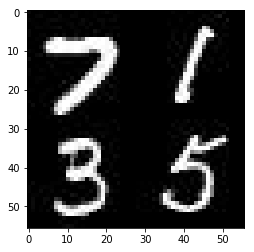

In [2]:
show_n_images = 5

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

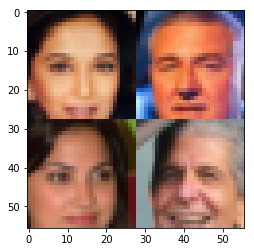

In [3]:
show_n_images = 5

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        # input is 28x28
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.get_shape())
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.get_shape())
        
        #x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        #bn3 = tf.layers.batch_normalization(x3, training=True)
        #relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.get_shape())
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*1024))
        #print(flat.get_shape())
        
        # Fully connected layer
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #print(out.get_shape())
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = (not is_train)):
        
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*1024)
        #print(x1.get_shape())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        # exludes BN on layer 1
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.get_shape())
        
        # Hidden layer 2
        x2 = tf.layers.conv2d_transpose(relu1, 512, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.get_shape())
        
        # Hidden layer 3
        x3 = tf.layers.conv2d_transpose(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu2.get_shape())
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # needs to return 28x28        
        
        out = tf.tanh(logits)
        #print(out.get_shape())
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Generator
    g_model = generator(input_z, out_channel_dim)
    
    # Discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses=[]
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            steps = 0
            
            for batch_images in get_batches(batch_size):
                
                # Step Counter
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizer
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})

                # Print loss
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                    
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                
                # Show every 100 steps
                if steps % 100 == 0:
                    #show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/3... Discriminator Loss: 0.0018... Generator Loss: 7.6581
Epoch 1/3... Discriminator Loss: 5.9921... Generator Loss: 0.0043
Epoch 1/3... Discriminator Loss: 1.2547... Generator Loss: 6.0275
Epoch 1/3... Discriminator Loss: 1.0967... Generator Loss: 1.6950
Epoch 1/3... Discriminator Loss: 5.7203... Generator Loss: 0.0058
Epoch 1/3... Discriminator Loss: 6.2750... Generator Loss: 0.0050
Epoch 1/3... Discriminator Loss: 5.9533... Generator Loss: 0.0069
Epoch 1/3... Discriminator Loss: 0.6253... Generator Loss: 4.5599
Epoch 1/3... Discriminator Loss: 0.1084... Generator Loss: 3.0093
Epoch 1/3... Discriminator Loss: 0.3521... Generator Loss: 1.5351


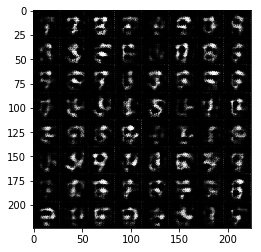

Epoch 1/3... Discriminator Loss: 0.1362... Generator Loss: 2.5450
Epoch 1/3... Discriminator Loss: 3.0360... Generator Loss: 0.1044
Epoch 1/3... Discriminator Loss: 2.1413... Generator Loss: 0.2204
Epoch 1/3... Discriminator Loss: 0.2282... Generator Loss: 2.3383
Epoch 1/3... Discriminator Loss: 0.1950... Generator Loss: 2.5348
Epoch 1/3... Discriminator Loss: 0.0186... Generator Loss: 4.9579
Epoch 1/3... Discriminator Loss: 0.4281... Generator Loss: 1.6907
Epoch 1/3... Discriminator Loss: 0.0321... Generator Loss: 5.9697
Epoch 1/3... Discriminator Loss: 0.1038... Generator Loss: 3.1174
Epoch 1/3... Discriminator Loss: 3.5750... Generator Loss: 0.0419


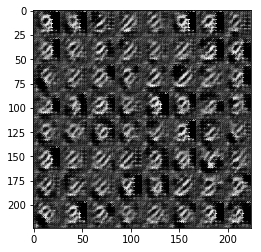

Epoch 1/3... Discriminator Loss: 3.7147... Generator Loss: 0.0403
Epoch 1/3... Discriminator Loss: 0.7094... Generator Loss: 1.0656
Epoch 1/3... Discriminator Loss: 0.9872... Generator Loss: 1.1708
Epoch 1/3... Discriminator Loss: 0.5490... Generator Loss: 1.8247
Epoch 1/3... Discriminator Loss: 0.0241... Generator Loss: 6.3888
Epoch 1/3... Discriminator Loss: 0.3108... Generator Loss: 3.7297
Epoch 1/3... Discriminator Loss: 0.3807... Generator Loss: 2.9474
Epoch 1/3... Discriminator Loss: 0.0454... Generator Loss: 5.6955
Epoch 1/3... Discriminator Loss: 11.8253... Generator Loss: 22.0596
Epoch 1/3... Discriminator Loss: 1.0097... Generator Loss: 1.0454


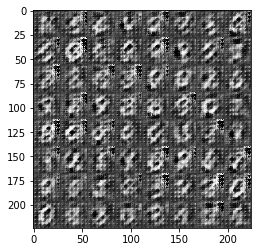

Epoch 1/3... Discriminator Loss: 0.1655... Generator Loss: 7.5606
Epoch 1/3... Discriminator Loss: 0.0375... Generator Loss: 10.1093
Epoch 1/3... Discriminator Loss: 0.9235... Generator Loss: 1.4694
Epoch 1/3... Discriminator Loss: 0.0112... Generator Loss: 19.9904
Epoch 1/3... Discriminator Loss: 0.0265... Generator Loss: 7.9733
Epoch 1/3... Discriminator Loss: 0.2045... Generator Loss: 3.8828
Epoch 1/3... Discriminator Loss: 0.8338... Generator Loss: 2.4479
Epoch 1/3... Discriminator Loss: 0.5731... Generator Loss: 5.5954
Epoch 1/3... Discriminator Loss: 1.9011... Generator Loss: 0.6044
Epoch 1/3... Discriminator Loss: 0.1673... Generator Loss: 6.4470


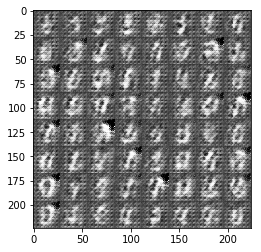

Epoch 1/3... Discriminator Loss: 1.5032... Generator Loss: 6.1437
Epoch 1/3... Discriminator Loss: 2.0979... Generator Loss: 3.1695
Epoch 1/3... Discriminator Loss: 2.0540... Generator Loss: 6.4405
Epoch 1/3... Discriminator Loss: 0.2699... Generator Loss: 3.4123
Epoch 1/3... Discriminator Loss: 0.2649... Generator Loss: 8.3584
Epoch 1/3... Discriminator Loss: 0.0673... Generator Loss: 4.8319
Epoch 1/3... Discriminator Loss: 0.7548... Generator Loss: 6.3441
Epoch 1/3... Discriminator Loss: 0.0909... Generator Loss: 6.4046
Epoch 1/3... Discriminator Loss: 0.0030... Generator Loss: 20.0306
Epoch 1/3... Discriminator Loss: 0.1531... Generator Loss: 4.1252


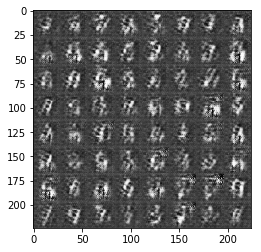

Epoch 1/3... Discriminator Loss: 0.3306... Generator Loss: 2.3029
Epoch 1/3... Discriminator Loss: 10.2524... Generator Loss: 9.0255
Epoch 1/3... Discriminator Loss: 5.4460... Generator Loss: 0.0082
Epoch 1/3... Discriminator Loss: 2.8748... Generator Loss: 0.1551
Epoch 1/3... Discriminator Loss: 8.0426... Generator Loss: 0.0010
Epoch 1/3... Discriminator Loss: 0.7651... Generator Loss: 1.3420
Epoch 1/3... Discriminator Loss: 0.7721... Generator Loss: 2.6490
Epoch 1/3... Discriminator Loss: 1.9024... Generator Loss: 0.3786
Epoch 1/3... Discriminator Loss: 0.0212... Generator Loss: 6.7066
Epoch 1/3... Discriminator Loss: 2.5122... Generator Loss: 0.4666


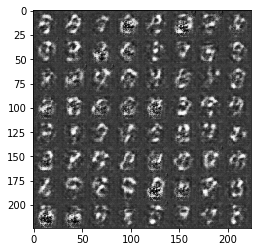

Epoch 1/3... Discriminator Loss: 0.8444... Generator Loss: 0.8457
Epoch 1/3... Discriminator Loss: 2.6138... Generator Loss: 0.5702
Epoch 1/3... Discriminator Loss: 2.4407... Generator Loss: 0.1898
Epoch 1/3... Discriminator Loss: 4.1166... Generator Loss: 0.0412
Epoch 1/3... Discriminator Loss: 1.5020... Generator Loss: 0.5061
Epoch 1/3... Discriminator Loss: 6.0495... Generator Loss: 0.0070
Epoch 1/3... Discriminator Loss: 5.0133... Generator Loss: 0.0090
Epoch 1/3... Discriminator Loss: 2.3146... Generator Loss: 6.8340
Epoch 1/3... Discriminator Loss: 2.8923... Generator Loss: 0.1099
Epoch 1/3... Discriminator Loss: 2.4023... Generator Loss: 0.1197


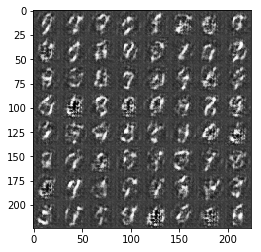

Epoch 1/3... Discriminator Loss: 2.4678... Generator Loss: 7.0447
Epoch 1/3... Discriminator Loss: 3.1832... Generator Loss: 0.0440
Epoch 1/3... Discriminator Loss: 0.7084... Generator Loss: 1.3372
Epoch 1/3... Discriminator Loss: 0.7776... Generator Loss: 0.9673
Epoch 1/3... Discriminator Loss: 3.9477... Generator Loss: 0.0765
Epoch 1/3... Discriminator Loss: 6.9561... Generator Loss: 0.0016
Epoch 1/3... Discriminator Loss: 5.9180... Generator Loss: 0.0037
Epoch 1/3... Discriminator Loss: 4.0781... Generator Loss: 0.0210
Epoch 1/3... Discriminator Loss: 3.6224... Generator Loss: 0.0346
Epoch 1/3... Discriminator Loss: 3.5159... Generator Loss: 0.0339


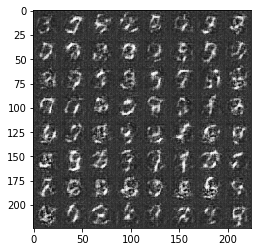

Epoch 1/3... Discriminator Loss: 2.9309... Generator Loss: 0.1064
Epoch 1/3... Discriminator Loss: 1.4977... Generator Loss: 0.6151
Epoch 1/3... Discriminator Loss: 0.8138... Generator Loss: 0.9297
Epoch 1/3... Discriminator Loss: 1.1630... Generator Loss: 0.8277
Epoch 1/3... Discriminator Loss: 3.4020... Generator Loss: 0.0745
Epoch 1/3... Discriminator Loss: 5.4666... Generator Loss: 0.0063
Epoch 1/3... Discriminator Loss: 3.4155... Generator Loss: 0.0474
Epoch 1/3... Discriminator Loss: 2.7730... Generator Loss: 6.0515
Epoch 1/3... Discriminator Loss: 2.2592... Generator Loss: 0.1659
Epoch 1/3... Discriminator Loss: 0.7509... Generator Loss: 1.3254


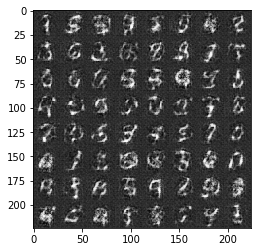

Epoch 1/3... Discriminator Loss: 2.6567... Generator Loss: 0.1219
Epoch 1/3... Discriminator Loss: 1.1726... Generator Loss: 0.7674
Epoch 1/3... Discriminator Loss: 2.1887... Generator Loss: 0.1952
Epoch 2/3... Discriminator Loss: 0.7400... Generator Loss: 0.9839
Epoch 2/3... Discriminator Loss: 0.8940... Generator Loss: 4.2219
Epoch 2/3... Discriminator Loss: 6.7189... Generator Loss: 11.2513
Epoch 2/3... Discriminator Loss: 4.3922... Generator Loss: 7.8814
Epoch 2/3... Discriminator Loss: 1.3701... Generator Loss: 0.8414
Epoch 2/3... Discriminator Loss: 5.0715... Generator Loss: 0.0118
Epoch 2/3... Discriminator Loss: 1.3060... Generator Loss: 3.2079
Epoch 2/3... Discriminator Loss: 2.4890... Generator Loss: 0.2098
Epoch 2/3... Discriminator Loss: 0.9845... Generator Loss: 0.6041
Epoch 2/3... Discriminator Loss: 1.3150... Generator Loss: 0.6086


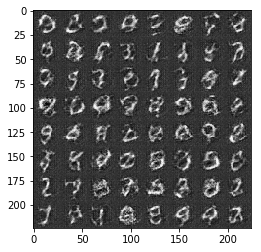

Epoch 2/3... Discriminator Loss: 1.2398... Generator Loss: 0.5711
Epoch 2/3... Discriminator Loss: 1.3813... Generator Loss: 0.3893
Epoch 2/3... Discriminator Loss: 0.5480... Generator Loss: 1.1982
Epoch 2/3... Discriminator Loss: 0.5621... Generator Loss: 1.4483
Epoch 2/3... Discriminator Loss: 0.7027... Generator Loss: 0.9032
Epoch 2/3... Discriminator Loss: 0.3927... Generator Loss: 3.5860
Epoch 2/3... Discriminator Loss: 0.2649... Generator Loss: 2.2788
Epoch 2/3... Discriminator Loss: 0.1248... Generator Loss: 2.8497
Epoch 2/3... Discriminator Loss: 0.2367... Generator Loss: 1.7921
Epoch 2/3... Discriminator Loss: 0.2131... Generator Loss: 2.1847


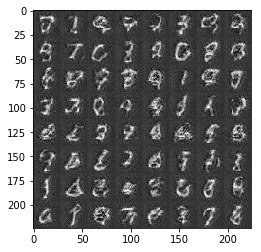

Epoch 2/3... Discriminator Loss: 0.0662... Generator Loss: 5.1185
Epoch 2/3... Discriminator Loss: 0.1035... Generator Loss: 2.8472
Epoch 2/3... Discriminator Loss: 1.4633... Generator Loss: 0.4901
Epoch 2/3... Discriminator Loss: 9.8432... Generator Loss: 0.0010
Epoch 2/3... Discriminator Loss: 6.4893... Generator Loss: 0.0034
Epoch 2/3... Discriminator Loss: 4.7395... Generator Loss: 0.0097
Epoch 2/3... Discriminator Loss: 1.3584... Generator Loss: 0.9084
Epoch 2/3... Discriminator Loss: 5.4358... Generator Loss: 0.0049
Epoch 2/3... Discriminator Loss: 1.8328... Generator Loss: 0.3241
Epoch 2/3... Discriminator Loss: 1.5499... Generator Loss: 0.4886


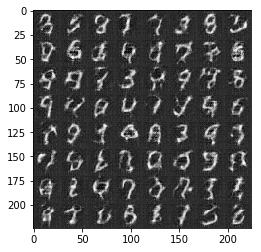

Epoch 2/3... Discriminator Loss: 3.4582... Generator Loss: 0.0707
Epoch 2/3... Discriminator Loss: 1.5582... Generator Loss: 0.3313
Epoch 2/3... Discriminator Loss: 3.4973... Generator Loss: 0.0438
Epoch 2/3... Discriminator Loss: 4.0346... Generator Loss: 0.0288
Epoch 2/3... Discriminator Loss: 2.1915... Generator Loss: 0.3677
Epoch 2/3... Discriminator Loss: 0.9023... Generator Loss: 0.7233
Epoch 2/3... Discriminator Loss: 1.3444... Generator Loss: 0.4000
Epoch 2/3... Discriminator Loss: 3.1741... Generator Loss: 0.0635
Epoch 2/3... Discriminator Loss: 0.3610... Generator Loss: 1.4316
Epoch 2/3... Discriminator Loss: 0.9044... Generator Loss: 0.6602


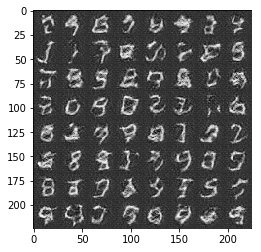

Epoch 2/3... Discriminator Loss: 0.4520... Generator Loss: 2.0355
Epoch 2/3... Discriminator Loss: 0.5291... Generator Loss: 1.2699
Epoch 2/3... Discriminator Loss: 0.6786... Generator Loss: 1.1533
Epoch 2/3... Discriminator Loss: 1.4502... Generator Loss: 0.5600
Epoch 2/3... Discriminator Loss: 0.2862... Generator Loss: 2.2815
Epoch 2/3... Discriminator Loss: 0.3205... Generator Loss: 1.8929
Epoch 2/3... Discriminator Loss: 3.5147... Generator Loss: 3.3044
Epoch 2/3... Discriminator Loss: 5.6819... Generator Loss: 7.8071
Epoch 2/3... Discriminator Loss: 5.2696... Generator Loss: 0.0065
Epoch 2/3... Discriminator Loss: 3.5019... Generator Loss: 0.0851


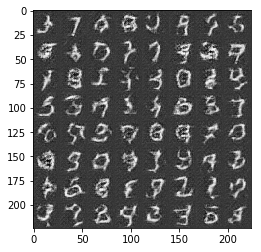

Epoch 2/3... Discriminator Loss: 4.5423... Generator Loss: 0.0139
Epoch 2/3... Discriminator Loss: 5.3808... Generator Loss: 0.0073
Epoch 2/3... Discriminator Loss: 5.0734... Generator Loss: 3.6050
Epoch 2/3... Discriminator Loss: 5.0452... Generator Loss: 0.0078
Epoch 2/3... Discriminator Loss: 5.8400... Generator Loss: 0.0094
Epoch 2/3... Discriminator Loss: 4.9946... Generator Loss: 0.0102
Epoch 2/3... Discriminator Loss: 0.9080... Generator Loss: 0.8602
Epoch 2/3... Discriminator Loss: 5.3146... Generator Loss: 0.0092
Epoch 2/3... Discriminator Loss: 1.4961... Generator Loss: 0.4376
Epoch 2/3... Discriminator Loss: 1.4054... Generator Loss: 0.4483


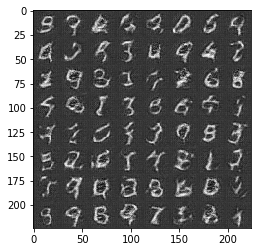

Epoch 2/3... Discriminator Loss: 1.3027... Generator Loss: 1.1733
Epoch 2/3... Discriminator Loss: 1.7766... Generator Loss: 0.5565
Epoch 2/3... Discriminator Loss: 1.3958... Generator Loss: 0.5133
Epoch 2/3... Discriminator Loss: 1.9578... Generator Loss: 0.3587
Epoch 2/3... Discriminator Loss: 0.4018... Generator Loss: 2.7298
Epoch 2/3... Discriminator Loss: 0.6743... Generator Loss: 1.0077
Epoch 2/3... Discriminator Loss: 1.8081... Generator Loss: 0.2781
Epoch 2/3... Discriminator Loss: 0.6509... Generator Loss: 1.2273
Epoch 2/3... Discriminator Loss: 0.2764... Generator Loss: 2.5359
Epoch 2/3... Discriminator Loss: 0.6421... Generator Loss: 1.0578


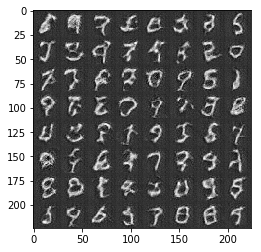

Epoch 2/3... Discriminator Loss: 0.1304... Generator Loss: 3.0887
Epoch 2/3... Discriminator Loss: 0.5803... Generator Loss: 1.6003
Epoch 2/3... Discriminator Loss: 0.1589... Generator Loss: 2.9388
Epoch 2/3... Discriminator Loss: 0.1708... Generator Loss: 2.5447
Epoch 2/3... Discriminator Loss: 0.6424... Generator Loss: 1.0596
Epoch 2/3... Discriminator Loss: 0.2426... Generator Loss: 2.2849
Epoch 2/3... Discriminator Loss: 1.2642... Generator Loss: 0.4504
Epoch 2/3... Discriminator Loss: 1.2679... Generator Loss: 0.7557
Epoch 2/3... Discriminator Loss: 3.8095... Generator Loss: 0.0319
Epoch 2/3... Discriminator Loss: 6.2165... Generator Loss: 0.0082


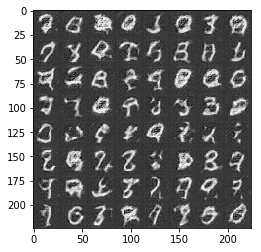

Epoch 2/3... Discriminator Loss: 3.0246... Generator Loss: 4.5948
Epoch 2/3... Discriminator Loss: 2.1112... Generator Loss: 1.7445
Epoch 2/3... Discriminator Loss: 2.1137... Generator Loss: 0.4644
Epoch 2/3... Discriminator Loss: 2.7921... Generator Loss: 2.5153
Epoch 2/3... Discriminator Loss: 1.9074... Generator Loss: 0.4822
Epoch 2/3... Discriminator Loss: 4.1719... Generator Loss: 0.0193
Epoch 2/3... Discriminator Loss: 2.2878... Generator Loss: 0.3089
Epoch 2/3... Discriminator Loss: 2.4770... Generator Loss: 0.1870
Epoch 2/3... Discriminator Loss: 5.1307... Generator Loss: 0.0120
Epoch 2/3... Discriminator Loss: 4.1772... Generator Loss: 0.0395


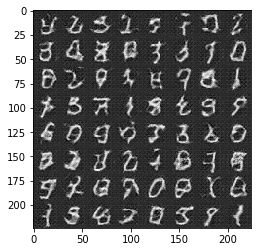

Epoch 2/3... Discriminator Loss: 4.2440... Generator Loss: 0.0156
Epoch 2/3... Discriminator Loss: 4.5704... Generator Loss: 4.5292
Epoch 2/3... Discriminator Loss: 1.4174... Generator Loss: 1.6864
Epoch 3/3... Discriminator Loss: 1.0478... Generator Loss: 0.9667
Epoch 3/3... Discriminator Loss: 0.7172... Generator Loss: 2.8870
Epoch 3/3... Discriminator Loss: 0.9834... Generator Loss: 2.1986
Epoch 3/3... Discriminator Loss: 3.1682... Generator Loss: 0.0912
Epoch 3/3... Discriminator Loss: 3.0340... Generator Loss: 0.1098
Epoch 3/3... Discriminator Loss: 1.5718... Generator Loss: 0.6986
Epoch 3/3... Discriminator Loss: 1.1903... Generator Loss: 0.6788
Epoch 3/3... Discriminator Loss: 0.3170... Generator Loss: 1.6903
Epoch 3/3... Discriminator Loss: 1.6086... Generator Loss: 0.6175
Epoch 3/3... Discriminator Loss: 1.6974... Generator Loss: 0.3683


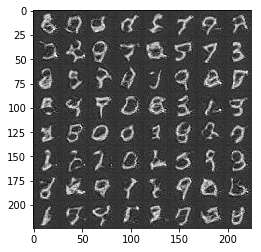

Epoch 3/3... Discriminator Loss: 0.1670... Generator Loss: 2.6109
Epoch 3/3... Discriminator Loss: 1.5091... Generator Loss: 0.3145
Epoch 3/3... Discriminator Loss: 1.1373... Generator Loss: 0.6863
Epoch 3/3... Discriminator Loss: 0.4689... Generator Loss: 1.8109
Epoch 3/3... Discriminator Loss: 0.3505... Generator Loss: 1.8838
Epoch 3/3... Discriminator Loss: 0.2099... Generator Loss: 1.9105
Epoch 3/3... Discriminator Loss: 0.0875... Generator Loss: 3.6193
Epoch 3/3... Discriminator Loss: 0.4190... Generator Loss: 1.8645
Epoch 3/3... Discriminator Loss: 1.6854... Generator Loss: 0.2803
Epoch 3/3... Discriminator Loss: 0.7445... Generator Loss: 1.3373


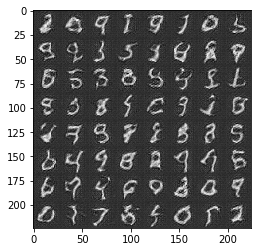

Epoch 3/3... Discriminator Loss: 0.0601... Generator Loss: 3.5537
Epoch 3/3... Discriminator Loss: 0.3772... Generator Loss: 1.9346
Epoch 3/3... Discriminator Loss: 0.0682... Generator Loss: 3.7092
Epoch 3/3... Discriminator Loss: 1.2584... Generator Loss: 0.5159
Epoch 3/3... Discriminator Loss: 0.2143... Generator Loss: 2.2880
Epoch 3/3... Discriminator Loss: 0.2877... Generator Loss: 1.7684
Epoch 3/3... Discriminator Loss: 0.5890... Generator Loss: 1.5119
Epoch 3/3... Discriminator Loss: 0.5536... Generator Loss: 1.2881
Epoch 3/3... Discriminator Loss: 0.0557... Generator Loss: 3.7955
Epoch 3/3... Discriminator Loss: 0.0958... Generator Loss: 3.1180


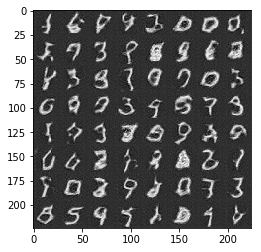

Epoch 3/3... Discriminator Loss: 0.1829... Generator Loss: 2.0971
Epoch 3/3... Discriminator Loss: 3.9624... Generator Loss: 0.0319
Epoch 3/3... Discriminator Loss: 16.5119... Generator Loss: 0.0000
Epoch 3/3... Discriminator Loss: 7.5556... Generator Loss: 0.0018
Epoch 3/3... Discriminator Loss: 6.5615... Generator Loss: 0.0063
Epoch 3/3... Discriminator Loss: 4.7464... Generator Loss: 0.0107
Epoch 3/3... Discriminator Loss: 2.8003... Generator Loss: 0.2789
Epoch 3/3... Discriminator Loss: 1.9561... Generator Loss: 0.7353
Epoch 3/3... Discriminator Loss: 1.7931... Generator Loss: 1.0488
Epoch 3/3... Discriminator Loss: 5.0487... Generator Loss: 0.0237


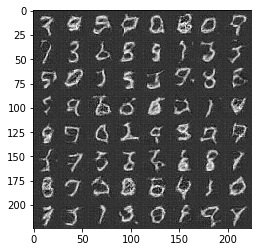

Epoch 3/3... Discriminator Loss: 1.7865... Generator Loss: 2.7904
Epoch 3/3... Discriminator Loss: 2.5617... Generator Loss: 0.1403
Epoch 3/3... Discriminator Loss: 3.6389... Generator Loss: 0.0516
Epoch 3/3... Discriminator Loss: 2.0818... Generator Loss: 0.2768
Epoch 3/3... Discriminator Loss: 4.0729... Generator Loss: 0.0298


KeyboardInterrupt: 

In [28]:
batch_size = 64
z_dim = 200
learning_rate = 0.001
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 12.9384... Generator Loss: 0.0000
Epoch 1/2... Discriminator Loss: 0.0786... Generator Loss: 37.6875
Epoch 1/2... Discriminator Loss: 8.9201... Generator Loss: 26.8174
Epoch 1/2... Discriminator Loss: 0.5600... Generator Loss: 8.1833
Epoch 1/2... Discriminator Loss: 0.2979... Generator Loss: 1.7333
Epoch 1/2... Discriminator Loss: 0.0079... Generator Loss: 15.8358
Epoch 1/2... Discriminator Loss: 0.0247... Generator Loss: 9.4994
Epoch 1/2... Discriminator Loss: 0.0214... Generator Loss: 5.3178
Epoch 1/2... Discriminator Loss: 23.4413... Generator Loss: 70.0148
Epoch 1/2... Discriminator Loss: 6.0163... Generator Loss: 26.8198


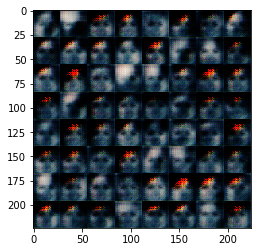

Epoch 1/2... Discriminator Loss: 0.0633... Generator Loss: 6.0375
Epoch 1/2... Discriminator Loss: 0.3212... Generator Loss: 1.9216
Epoch 1/2... Discriminator Loss: 0.2647... Generator Loss: 4.8962
Epoch 1/2... Discriminator Loss: 0.4634... Generator Loss: 1.8586
Epoch 1/2... Discriminator Loss: 0.3275... Generator Loss: 2.5360
Epoch 1/2... Discriminator Loss: 0.2664... Generator Loss: 2.5417
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 1.2024
Epoch 1/2... Discriminator Loss: 0.4872... Generator Loss: 2.9682
Epoch 1/2... Discriminator Loss: 0.4827... Generator Loss: 2.1561
Epoch 1/2... Discriminator Loss: 0.0924... Generator Loss: 5.8291


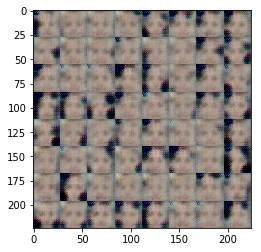

Epoch 1/2... Discriminator Loss: 0.0173... Generator Loss: 16.6603
Epoch 1/2... Discriminator Loss: 0.2972... Generator Loss: 2.8244
Epoch 1/2... Discriminator Loss: 0.5263... Generator Loss: 2.8314
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 1.0508
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 2.2564
Epoch 1/2... Discriminator Loss: 0.4324... Generator Loss: 3.2565
Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 0.5513
Epoch 1/2... Discriminator Loss: 0.7942... Generator Loss: 1.4179
Epoch 1/2... Discriminator Loss: 7.7710... Generator Loss: 2.1388
Epoch 1/2... Discriminator Loss: 1.8110... Generator Loss: 0.3881


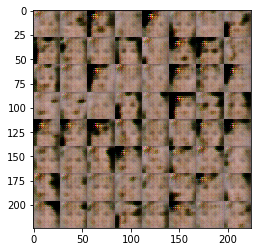

Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 0.7109
Epoch 1/2... Discriminator Loss: 1.0115... Generator Loss: 1.1733
Epoch 1/2... Discriminator Loss: 0.0327... Generator Loss: 5.8019
Epoch 1/2... Discriminator Loss: 0.0571... Generator Loss: 5.4141
Epoch 1/2... Discriminator Loss: 0.1667... Generator Loss: 2.9408
Epoch 1/2... Discriminator Loss: 0.2937... Generator Loss: 2.7726
Epoch 1/2... Discriminator Loss: 0.6471... Generator Loss: 2.5093
Epoch 1/2... Discriminator Loss: 0.0612... Generator Loss: 5.5119
Epoch 1/2... Discriminator Loss: 0.7353... Generator Loss: 3.0026
Epoch 1/2... Discriminator Loss: 0.5945... Generator Loss: 6.3533


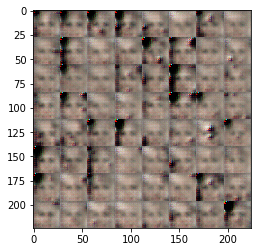

Epoch 1/2... Discriminator Loss: 1.6057... Generator Loss: 1.4070
Epoch 1/2... Discriminator Loss: 1.1075... Generator Loss: 2.7727
Epoch 1/2... Discriminator Loss: 2.2333... Generator Loss: 0.5438
Epoch 1/2... Discriminator Loss: 0.0155... Generator Loss: 8.4023
Epoch 1/2... Discriminator Loss: 1.0055... Generator Loss: 1.1206
Epoch 1/2... Discriminator Loss: 0.2495... Generator Loss: 6.5539
Epoch 1/2... Discriminator Loss: 1.9622... Generator Loss: 0.6726
Epoch 1/2... Discriminator Loss: 0.3715... Generator Loss: 2.6338
Epoch 1/2... Discriminator Loss: 2.4349... Generator Loss: 6.4242
Epoch 1/2... Discriminator Loss: 0.6206... Generator Loss: 2.2735


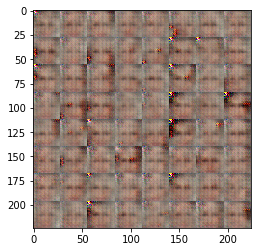

Epoch 1/2... Discriminator Loss: 0.7714... Generator Loss: 2.2951
Epoch 1/2... Discriminator Loss: 0.6682... Generator Loss: 2.2769
Epoch 1/2... Discriminator Loss: 1.2308... Generator Loss: 1.4626
Epoch 1/2... Discriminator Loss: 0.2586... Generator Loss: 3.3905
Epoch 1/2... Discriminator Loss: 0.0370... Generator Loss: 9.0885
Epoch 1/2... Discriminator Loss: 3.2682... Generator Loss: 0.0473
Epoch 1/2... Discriminator Loss: 4.8438... Generator Loss: 0.3208
Epoch 1/2... Discriminator Loss: 1.0837... Generator Loss: 3.5407
Epoch 1/2... Discriminator Loss: 0.0198... Generator Loss: 5.1655
Epoch 1/2... Discriminator Loss: 0.1428... Generator Loss: 10.4298


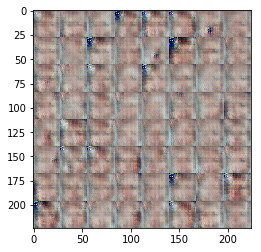

Epoch 1/2... Discriminator Loss: 0.7399... Generator Loss: 1.6544
Epoch 1/2... Discriminator Loss: 2.0768... Generator Loss: 1.6782
Epoch 1/2... Discriminator Loss: 0.8944... Generator Loss: 1.5238
Epoch 1/2... Discriminator Loss: 3.0871... Generator Loss: 0.2572
Epoch 1/2... Discriminator Loss: 5.0133... Generator Loss: 0.5450
Epoch 1/2... Discriminator Loss: 2.6273... Generator Loss: 1.4481
Epoch 1/2... Discriminator Loss: 0.2157... Generator Loss: 5.2785
Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 5.0497
Epoch 1/2... Discriminator Loss: 0.0016... Generator Loss: 13.6207
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 2.2631


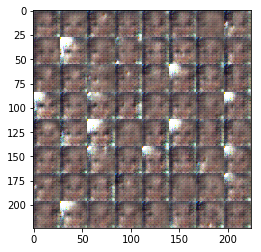

Epoch 1/2... Discriminator Loss: 0.7764... Generator Loss: 1.5584
Epoch 1/2... Discriminator Loss: 0.7018... Generator Loss: 2.5350
Epoch 1/2... Discriminator Loss: 0.0818... Generator Loss: 8.8057
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 1.4438
Epoch 1/2... Discriminator Loss: 6.6031... Generator Loss: 0.0108
Epoch 1/2... Discriminator Loss: 6.6285... Generator Loss: 0.0031
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.7121
Epoch 1/2... Discriminator Loss: 5.9569... Generator Loss: 0.0074
Epoch 1/2... Discriminator Loss: 0.2683... Generator Loss: 4.5518
Epoch 1/2... Discriminator Loss: 5.6434... Generator Loss: 0.0042


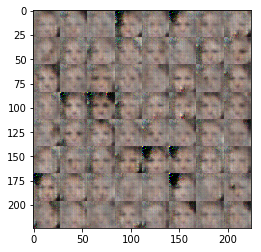

Epoch 1/2... Discriminator Loss: 0.0374... Generator Loss: 5.2503
Epoch 1/2... Discriminator Loss: 0.0269... Generator Loss: 5.5950
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 2.0037
Epoch 1/2... Discriminator Loss: 10.8468... Generator Loss: 0.0000
Epoch 1/2... Discriminator Loss: 5.3468... Generator Loss: 0.0082
Epoch 1/2... Discriminator Loss: 3.2231... Generator Loss: 0.0474
Epoch 1/2... Discriminator Loss: 4.0725... Generator Loss: 3.4728
Epoch 1/2... Discriminator Loss: 3.2563... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 0.0766... Generator Loss: 4.3300
Epoch 1/2... Discriminator Loss: 2.4042... Generator Loss: 0.4094


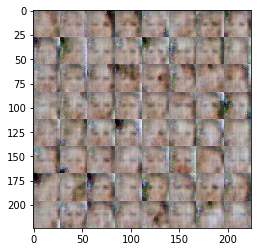

Epoch 1/2... Discriminator Loss: 0.5555... Generator Loss: 3.3447
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 0.7068
Epoch 1/2... Discriminator Loss: 0.1356... Generator Loss: 7.0081
Epoch 1/2... Discriminator Loss: 0.0040... Generator Loss: 14.4701
Epoch 1/2... Discriminator Loss: 0.1889... Generator Loss: 6.2144
Epoch 1/2... Discriminator Loss: 2.8715... Generator Loss: 0.0850
Epoch 1/2... Discriminator Loss: 3.4259... Generator Loss: 0.3849
Epoch 1/2... Discriminator Loss: 6.7960... Generator Loss: 0.1137
Epoch 1/2... Discriminator Loss: 0.0297... Generator Loss: 7.0632
Epoch 1/2... Discriminator Loss: 0.7774... Generator Loss: 0.8153


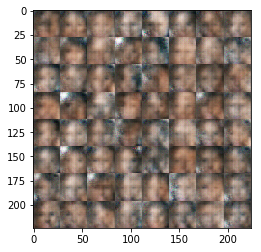

Epoch 1/2... Discriminator Loss: 0.3801... Generator Loss: 2.9804
Epoch 1/2... Discriminator Loss: 0.7473... Generator Loss: 1.7453
Epoch 1/2... Discriminator Loss: 0.0419... Generator Loss: 6.3880
Epoch 1/2... Discriminator Loss: 0.1131... Generator Loss: 3.3956
Epoch 1/2... Discriminator Loss: 0.2314... Generator Loss: 3.6027
Epoch 1/2... Discriminator Loss: 3.6898... Generator Loss: 0.0621
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.4410
Epoch 1/2... Discriminator Loss: 1.4330... Generator Loss: 3.2506
Epoch 1/2... Discriminator Loss: 4.2520... Generator Loss: 3.0448
Epoch 1/2... Discriminator Loss: 0.4686... Generator Loss: 5.0916


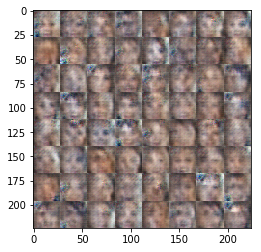

Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 3.6385
Epoch 1/2... Discriminator Loss: 2.7057... Generator Loss: 0.0958
Epoch 1/2... Discriminator Loss: 3.9110... Generator Loss: 0.0675
Epoch 1/2... Discriminator Loss: 0.6439... Generator Loss: 1.7756
Epoch 1/2... Discriminator Loss: 0.1070... Generator Loss: 4.3152
Epoch 1/2... Discriminator Loss: 0.6288... Generator Loss: 2.5484
Epoch 1/2... Discriminator Loss: 0.0498... Generator Loss: 4.4612
Epoch 1/2... Discriminator Loss: 0.0973... Generator Loss: 3.1121
Epoch 1/2... Discriminator Loss: 2.8604... Generator Loss: 11.3626
Epoch 1/2... Discriminator Loss: 3.0750... Generator Loss: 9.2887


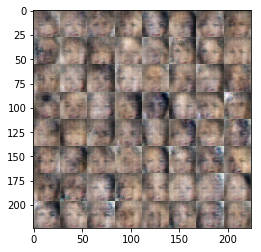

Epoch 1/2... Discriminator Loss: 4.6503... Generator Loss: 2.0342
Epoch 1/2... Discriminator Loss: 0.5351... Generator Loss: 3.5833
Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 2.2746
Epoch 1/2... Discriminator Loss: 0.2936... Generator Loss: 2.7591
Epoch 1/2... Discriminator Loss: 2.7120... Generator Loss: 0.0797
Epoch 1/2... Discriminator Loss: 0.0556... Generator Loss: 3.5331
Epoch 1/2... Discriminator Loss: 0.1275... Generator Loss: 8.0531
Epoch 1/2... Discriminator Loss: 4.9664... Generator Loss: 0.0109
Epoch 1/2... Discriminator Loss: 3.0799... Generator Loss: 11.4717
Epoch 1/2... Discriminator Loss: 1.0418... Generator Loss: 0.9212


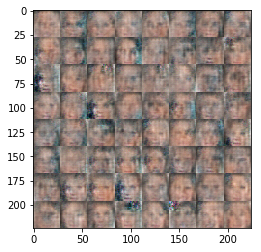

Epoch 1/2... Discriminator Loss: 2.7644... Generator Loss: 0.0795
Epoch 1/2... Discriminator Loss: 0.6660... Generator Loss: 1.4644
Epoch 1/2... Discriminator Loss: 2.3757... Generator Loss: 3.1227
Epoch 1/2... Discriminator Loss: 2.0076... Generator Loss: 4.0376
Epoch 1/2... Discriminator Loss: 2.6189... Generator Loss: 0.1109
Epoch 1/2... Discriminator Loss: 0.6465... Generator Loss: 1.3673
Epoch 1/2... Discriminator Loss: 4.0374... Generator Loss: 0.0337
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 5.7941
Epoch 1/2... Discriminator Loss: 4.0566... Generator Loss: 0.0253
Epoch 1/2... Discriminator Loss: 4.9400... Generator Loss: 0.0158


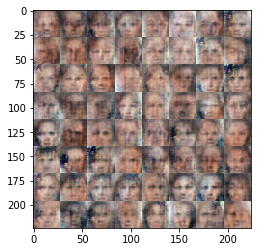

Epoch 1/2... Discriminator Loss: 2.5878... Generator Loss: 0.1016
Epoch 1/2... Discriminator Loss: 0.5264... Generator Loss: 3.0553
Epoch 1/2... Discriminator Loss: 0.2144... Generator Loss: 2.8501
Epoch 1/2... Discriminator Loss: 5.0088... Generator Loss: 7.2144
Epoch 1/2... Discriminator Loss: 5.3589... Generator Loss: 0.0100
Epoch 1/2... Discriminator Loss: 2.1691... Generator Loss: 0.2104
Epoch 1/2... Discriminator Loss: 0.3737... Generator Loss: 2.3833
Epoch 1/2... Discriminator Loss: 5.5579... Generator Loss: 0.0064
Epoch 1/2... Discriminator Loss: 1.7646... Generator Loss: 5.5542
Epoch 1/2... Discriminator Loss: 0.6270... Generator Loss: 1.3733


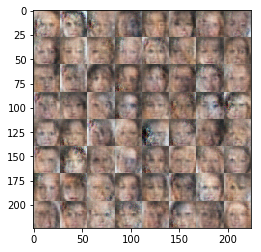

Epoch 1/2... Discriminator Loss: 3.8039... Generator Loss: 0.0676
Epoch 1/2... Discriminator Loss: 0.7588... Generator Loss: 2.3879
Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 0.5235
Epoch 1/2... Discriminator Loss: 2.3008... Generator Loss: 0.1305
Epoch 1/2... Discriminator Loss: 1.4894... Generator Loss: 4.6290
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 2.5281
Epoch 1/2... Discriminator Loss: 6.7837... Generator Loss: 0.0028
Epoch 1/2... Discriminator Loss: 0.5167... Generator Loss: 1.1529
Epoch 1/2... Discriminator Loss: 0.6764... Generator Loss: 1.1087
Epoch 1/2... Discriminator Loss: 1.0289... Generator Loss: 0.9514


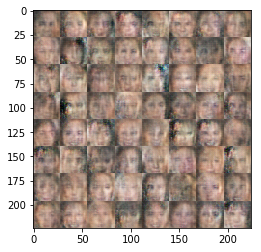

Epoch 1/2... Discriminator Loss: 2.3100... Generator Loss: 0.2051
Epoch 1/2... Discriminator Loss: 1.0826... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 0.3987... Generator Loss: 5.9523
Epoch 1/2... Discriminator Loss: 0.1276... Generator Loss: 4.6971
Epoch 1/2... Discriminator Loss: 2.6025... Generator Loss: 2.8254
Epoch 1/2... Discriminator Loss: 5.0590... Generator Loss: 0.0093
Epoch 1/2... Discriminator Loss: 1.5144... Generator Loss: 2.6853
Epoch 1/2... Discriminator Loss: 2.0669... Generator Loss: 0.2097
Epoch 1/2... Discriminator Loss: 3.9852... Generator Loss: 0.0278
Epoch 1/2... Discriminator Loss: 4.8638... Generator Loss: 0.0101


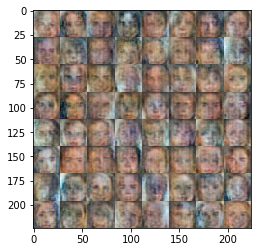

Epoch 1/2... Discriminator Loss: 0.8467... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 4.0384... Generator Loss: 0.0216
Epoch 1/2... Discriminator Loss: 1.6858... Generator Loss: 2.1074
Epoch 1/2... Discriminator Loss: 2.5181... Generator Loss: 0.1315
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 3.1894
Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 1.2070
Epoch 1/2... Discriminator Loss: 1.9165... Generator Loss: 2.3084
Epoch 1/2... Discriminator Loss: 0.9430... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 0.8148... Generator Loss: 1.5866
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 2.9597


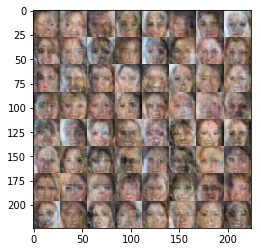

Epoch 1/2... Discriminator Loss: 0.9481... Generator Loss: 1.9110
Epoch 1/2... Discriminator Loss: 2.0720... Generator Loss: 0.1569
Epoch 1/2... Discriminator Loss: 2.3161... Generator Loss: 0.1303
Epoch 1/2... Discriminator Loss: 0.4148... Generator Loss: 1.8567
Epoch 1/2... Discriminator Loss: 0.3957... Generator Loss: 1.5757
Epoch 1/2... Discriminator Loss: 3.3366... Generator Loss: 0.0432
Epoch 1/2... Discriminator Loss: 2.6171... Generator Loss: 0.1903
Epoch 1/2... Discriminator Loss: 0.8329... Generator Loss: 1.4923
Epoch 1/2... Discriminator Loss: 2.0107... Generator Loss: 0.1964
Epoch 1/2... Discriminator Loss: 0.4493... Generator Loss: 3.3333


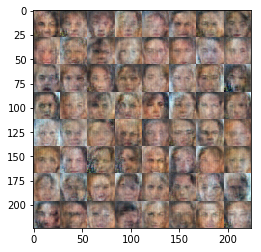

Epoch 1/2... Discriminator Loss: 5.1003... Generator Loss: 2.3732
Epoch 1/2... Discriminator Loss: 3.1310... Generator Loss: 0.0635
Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 0.4150
Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.3485
Epoch 1/2... Discriminator Loss: 1.7287... Generator Loss: 2.0427
Epoch 1/2... Discriminator Loss: 2.0051... Generator Loss: 0.1626
Epoch 1/2... Discriminator Loss: 2.4167... Generator Loss: 0.1060
Epoch 1/2... Discriminator Loss: 0.9988... Generator Loss: 0.9185
Epoch 1/2... Discriminator Loss: 2.9915... Generator Loss: 0.0623
Epoch 1/2... Discriminator Loss: 1.3951... Generator Loss: 0.4999


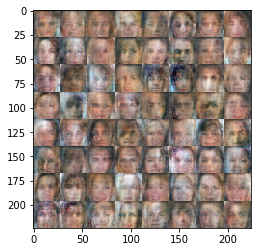

Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 0.4940
Epoch 1/2... Discriminator Loss: 1.7549... Generator Loss: 0.2228
Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 2.6692
Epoch 1/2... Discriminator Loss: 0.9854... Generator Loss: 1.3546
Epoch 1/2... Discriminator Loss: 3.2943... Generator Loss: 0.0491
Epoch 1/2... Discriminator Loss: 2.5559... Generator Loss: 0.1134
Epoch 1/2... Discriminator Loss: 0.8067... Generator Loss: 1.2942
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 1.5625
Epoch 1/2... Discriminator Loss: 4.8390... Generator Loss: 0.0095
Epoch 1/2... Discriminator Loss: 4.2981... Generator Loss: 0.0165


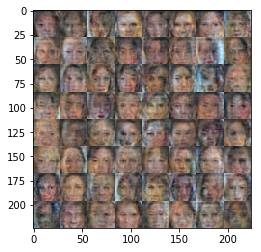

Epoch 1/2... Discriminator Loss: 1.4296... Generator Loss: 0.3859
Epoch 1/2... Discriminator Loss: 3.6426... Generator Loss: 0.0289
Epoch 1/2... Discriminator Loss: 3.6226... Generator Loss: 0.0299
Epoch 1/2... Discriminator Loss: 3.8673... Generator Loss: 0.0282
Epoch 1/2... Discriminator Loss: 2.5425... Generator Loss: 0.0931
Epoch 1/2... Discriminator Loss: 3.0181... Generator Loss: 0.0623
Epoch 1/2... Discriminator Loss: 1.6590... Generator Loss: 0.3193
Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 0.6728
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 1.3451
Epoch 1/2... Discriminator Loss: 1.6454... Generator Loss: 0.3730


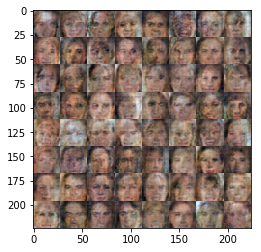

Epoch 1/2... Discriminator Loss: 1.5895... Generator Loss: 0.6277
Epoch 1/2... Discriminator Loss: 2.5306... Generator Loss: 0.1069
Epoch 1/2... Discriminator Loss: 2.2860... Generator Loss: 0.1288
Epoch 1/2... Discriminator Loss: 1.5636... Generator Loss: 0.2973
Epoch 1/2... Discriminator Loss: 1.5076... Generator Loss: 0.3561
Epoch 1/2... Discriminator Loss: 2.1106... Generator Loss: 0.9117
Epoch 1/2... Discriminator Loss: 1.2118... Generator Loss: 0.9718
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.7267
Epoch 1/2... Discriminator Loss: 1.0676... Generator Loss: 1.5655
Epoch 1/2... Discriminator Loss: 1.7148... Generator Loss: 1.8371


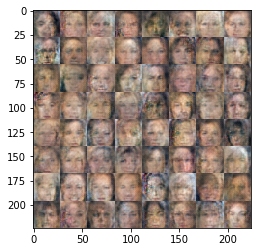

Epoch 1/2... Discriminator Loss: 1.3758... Generator Loss: 1.1410
Epoch 1/2... Discriminator Loss: 1.4796... Generator Loss: 0.4542
Epoch 1/2... Discriminator Loss: 1.5999... Generator Loss: 0.2904
Epoch 1/2... Discriminator Loss: 3.1192... Generator Loss: 0.0597
Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 0.5951
Epoch 1/2... Discriminator Loss: 1.0043... Generator Loss: 0.9334
Epoch 1/2... Discriminator Loss: 2.6847... Generator Loss: 0.0886
Epoch 1/2... Discriminator Loss: 2.2131... Generator Loss: 0.2077
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 2.2146
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.5654


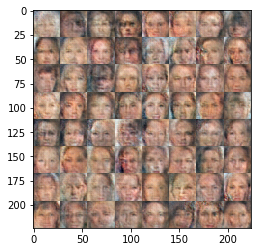

Epoch 1/2... Discriminator Loss: 2.5739... Generator Loss: 0.0891
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 0.5726
Epoch 1/2... Discriminator Loss: 2.9446... Generator Loss: 0.0617
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 1.5314... Generator Loss: 0.4399
Epoch 1/2... Discriminator Loss: 3.9697... Generator Loss: 0.0250
Epoch 1/2... Discriminator Loss: 2.5854... Generator Loss: 0.1158
Epoch 1/2... Discriminator Loss: 2.8207... Generator Loss: 0.0755
Epoch 1/2... Discriminator Loss: 1.8200... Generator Loss: 0.2675
Epoch 1/2... Discriminator Loss: 3.0611... Generator Loss: 0.0530


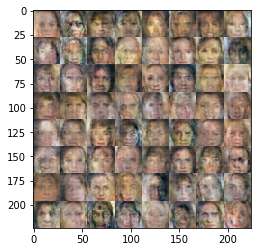

Epoch 1/2... Discriminator Loss: 2.0587... Generator Loss: 0.1577
Epoch 1/2... Discriminator Loss: 2.0538... Generator Loss: 0.1910
Epoch 1/2... Discriminator Loss: 2.6190... Generator Loss: 0.0806
Epoch 1/2... Discriminator Loss: 1.7322... Generator Loss: 0.2934
Epoch 1/2... Discriminator Loss: 1.7838... Generator Loss: 0.2263
Epoch 1/2... Discriminator Loss: 2.0477... Generator Loss: 0.1980
Epoch 1/2... Discriminator Loss: 1.9492... Generator Loss: 1.7527
Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 1.0425
Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 0.9600
Epoch 1/2... Discriminator Loss: 1.8134... Generator Loss: 0.3316


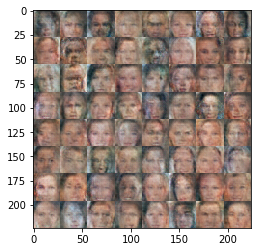

Epoch 1/2... Discriminator Loss: 3.1669... Generator Loss: 0.0692
Epoch 1/2... Discriminator Loss: 1.8037... Generator Loss: 0.2961
Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 0.4323
Epoch 1/2... Discriminator Loss: 2.1187... Generator Loss: 0.1657
Epoch 1/2... Discriminator Loss: 1.7664... Generator Loss: 0.2507
Epoch 1/2... Discriminator Loss: 2.3610... Generator Loss: 1.4068
Epoch 1/2... Discriminator Loss: 1.5229... Generator Loss: 0.4068
Epoch 1/2... Discriminator Loss: 1.6515... Generator Loss: 0.2737
Epoch 1/2... Discriminator Loss: 1.7873... Generator Loss: 0.2529
Epoch 1/2... Discriminator Loss: 2.2978... Generator Loss: 0.9749


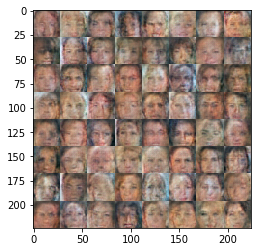

Epoch 1/2... Discriminator Loss: 2.7968... Generator Loss: 0.0785
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 0.3521
Epoch 1/2... Discriminator Loss: 2.5096... Generator Loss: 0.1026
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 1.0869
Epoch 1/2... Discriminator Loss: 1.3180... Generator Loss: 0.6733
Epoch 1/2... Discriminator Loss: 2.2217... Generator Loss: 0.1630
Epoch 1/2... Discriminator Loss: 2.0717... Generator Loss: 0.1708
Epoch 1/2... Discriminator Loss: 3.1086... Generator Loss: 1.5160
Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 0.9647
Epoch 1/2... Discriminator Loss: 2.1903... Generator Loss: 0.4543


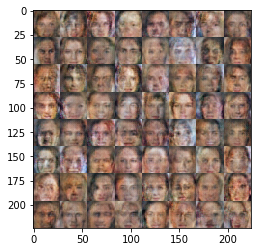

Epoch 1/2... Discriminator Loss: 3.4084... Generator Loss: 0.0362
Epoch 1/2... Discriminator Loss: 2.0293... Generator Loss: 0.1766
Epoch 1/2... Discriminator Loss: 3.1467... Generator Loss: 0.0468
Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 0.6657
Epoch 1/2... Discriminator Loss: 2.5865... Generator Loss: 0.0877
Epoch 1/2... Discriminator Loss: 2.1729... Generator Loss: 0.1777
Epoch 1/2... Discriminator Loss: 2.7336... Generator Loss: 0.0752
Epoch 1/2... Discriminator Loss: 2.2393... Generator Loss: 0.1287
Epoch 1/2... Discriminator Loss: 1.6914... Generator Loss: 0.2951
Epoch 1/2... Discriminator Loss: 2.7683... Generator Loss: 0.0677


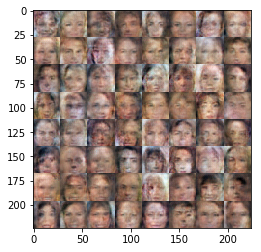

Epoch 1/2... Discriminator Loss: 1.8282... Generator Loss: 1.1201
Epoch 1/2... Discriminator Loss: 1.9413... Generator Loss: 0.2119
Epoch 1/2... Discriminator Loss: 2.2072... Generator Loss: 0.1637
Epoch 1/2... Discriminator Loss: 2.8614... Generator Loss: 0.0759
Epoch 1/2... Discriminator Loss: 1.5996... Generator Loss: 0.8513
Epoch 1/2... Discriminator Loss: 3.3960... Generator Loss: 0.0430
Epoch 1/2... Discriminator Loss: 3.3189... Generator Loss: 0.0421
Epoch 1/2... Discriminator Loss: 2.0250... Generator Loss: 0.1964
Epoch 1/2... Discriminator Loss: 1.5685... Generator Loss: 0.3676
Epoch 1/2... Discriminator Loss: 2.8113... Generator Loss: 0.0711


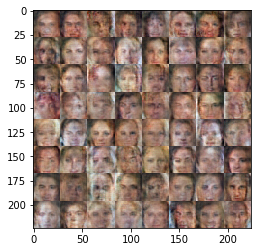

Epoch 1/2... Discriminator Loss: 1.6651... Generator Loss: 0.3091
Epoch 1/2... Discriminator Loss: 2.2017... Generator Loss: 0.2114
Epoch 1/2... Discriminator Loss: 2.4480... Generator Loss: 0.1066
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.4285
Epoch 1/2... Discriminator Loss: 1.6909... Generator Loss: 0.3599
Epoch 1/2... Discriminator Loss: 2.5739... Generator Loss: 0.1054
Epoch 1/2... Discriminator Loss: 2.7767... Generator Loss: 0.1115
Epoch 1/2... Discriminator Loss: 3.2067... Generator Loss: 0.0697
Epoch 1/2... Discriminator Loss: 2.1382... Generator Loss: 0.1400
Epoch 1/2... Discriminator Loss: 2.0655... Generator Loss: 0.1786


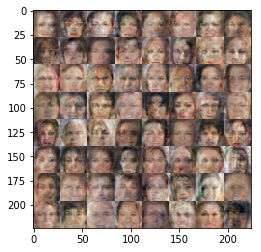

Epoch 1/2... Discriminator Loss: 2.3255... Generator Loss: 0.1091
Epoch 1/2... Discriminator Loss: 2.0421... Generator Loss: 0.2312
Epoch 1/2... Discriminator Loss: 2.0679... Generator Loss: 0.9697
Epoch 1/2... Discriminator Loss: 2.1790... Generator Loss: 0.1953
Epoch 1/2... Discriminator Loss: 2.1596... Generator Loss: 0.1456
Epoch 1/2... Discriminator Loss: 1.7037... Generator Loss: 0.3119
Epoch 2/2... Discriminator Loss: 1.5088... Generator Loss: 0.4012
Epoch 2/2... Discriminator Loss: 2.0199... Generator Loss: 0.1627
Epoch 2/2... Discriminator Loss: 1.8081... Generator Loss: 0.9259
Epoch 2/2... Discriminator Loss: 2.0494... Generator Loss: 0.2114
Epoch 2/2... Discriminator Loss: 1.7966... Generator Loss: 0.2753
Epoch 2/2... Discriminator Loss: 2.7762... Generator Loss: 0.0693
Epoch 2/2... Discriminator Loss: 2.1376... Generator Loss: 0.1531
Epoch 2/2... Discriminator Loss: 1.7988... Generator Loss: 0.3783
Epoch 2/2... Discriminator Loss: 2.3263... Generator Loss: 0.1257
Epoch 2/2.

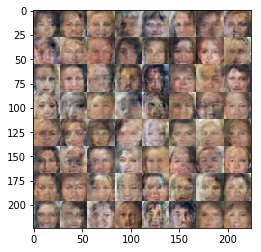

Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 0.5916
Epoch 2/2... Discriminator Loss: 1.4845... Generator Loss: 0.3774


KeyboardInterrupt: 

In [29]:
batch_size = 64
z_dim = 200
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.